# Categorical VAE using VI with Mixture of Discrete Normalizing Flows

Follows the implementation from https://github.com/ericjang/gumbel-softmax

## Imports and Helper Functions

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfpd

import copy
import time

In [2]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(relativeCreated)6d %(message)s')

In [3]:
tf.__version__, tfp.__version__

('2.2.0', '0.9.0')

In [4]:
import sys
sys.path.append('../mdnf')

In [5]:
import aux
import flows_mixture
import flows_factorized
import base_mixtures
import base_constructors
import inference

## Configuration

In [6]:
# can be run as a script with args in format KEY=VAL,KEY=[STRVAL],...
args = aux.parse_script_args() 

  3922 parsing: <-f>


In [7]:
# base distribution type (p -> delta)
# see create_base_mixture in base_constructors.py for options
BASE_SPECIFICATION = args.get("BASE_SPECIFICATION", "p") 

B = args.get("B", 40) # how many flows in mixture
N = args.get("N", 10) # how many latent variables
K = args.get("K", 2) # how many categories each

OPTIMIZER = args.get("OPTIMIZER", "ADAM")
LR = args.get("LR", 0.001)

# Temperature hyperparameter
BASE_TEMP = args.get("BASE_TEMP", 100.0)
ANNEAL_RATE = args.get("ANNEAL_RATE", 0.0005)
E_ANNEAL_RATE = args.get("E_ANNEAL_RATE", 0.01)
MIN_TEMP = args.get("MIN_TEMP", 0.001)

NSAMPLES = args.get("NSAMPLES", 1) # how many samples per data point in each step (=how many ELBOs evaluations)
BATCH_SIZE = 128 # how many samples in minibatch
NUM_ITERS = 20000 # how many iterations

## Approximiation: bases & flows

In [8]:
base = base_constructors.create_categorical_blocks(N, K, B, BASE_SPECIFICATION, 
                                          independent_variables=True); 
logger.info("base = %s" % base)

  4091 base = <class 'base_mixtures.FactorizedIndependentCategoricalMixture'>(N=10 (#dims), B=40 (#components), K=2 (#categories) mixing_probs=tf.Tensor(
[0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.0...)


In [9]:
temperature = tf.Variable(BASE_TEMP, name="temperature") #!

flows = [flows_factorized.DiscreteFactorizedFlow(N, K, temperature=temperature) for _ in range(B)]
mixture = flows_mixture.DiscreteFlowsMixture(N, K, B, flows=flows)

## Inference

In [10]:
OPTIMIZERS = {"RMS": tf.keras.optimizers.RMSprop,
              "ADAM": tf.keras.optimizers.Adam}
if OPTIMIZER not in OPTIMIZERS: raise ValueError("Unknown optimizer!")
optimizer_class = OPTIMIZERS[OPTIMIZER]
optimizer = optimizer_class(learning_rate=LR)

logger.info("optimizer=%s lr=%s" % (optimizer, LR))

  4193 optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f4fd8209b90> lr=0.001


## Model

In [11]:
class CategoricalVAE(tf.Module):

    def __init__(self, base, mixture, N, K, name=None):
        """
        
            Args:
                N  number of variables
                K  number of categories for each variable
                B  number of components in a mixture of flows
        """
        super(CategoricalVAE, self).__init__(name=name)
        
        self.base = base
        self.mixture = mixture

        self.N = N # number of categorical distributions
        self.K = K # number of classes
        
        
        self.calc_logits_z = tf.keras.Sequential([ # encoder
                                             tf.keras.layers.Flatten(name="encoder0"),
                                             tf.keras.layers.Dense(512, activation="relu", 
                                                                   input_shape=(None, 784), name="encoder1"),
                                             tf.keras.layers.Dense(256, activation="relu", name="encoder2"),
                                             tf.keras.layers.Dense(K*N, activation=None, name="encoder3"),
                                             tf.keras.layers.Reshape( [N,K] , name="encoder4")
                                            ], name="encoder")

        self.calc_logits_x = tf.keras.Sequential( # decoder
                                            [tf.keras.layers.Flatten(name="decoder0"),
                                             tf.keras.layers.Dense(256, activation="relu", name="decoder1"),
                                             tf.keras.layers.Dense(512, activation="relu", name="decoder2"),
                                             tf.keras.layers.Dense(784, activation=None, name="decoder3"),
                                            ], name="decoder")         
        
        B = len(mixture.flows)
        self.calc_logits_flows = tf.keras.Sequential([ 
                                             tf.keras.layers.Flatten(name="flows0"),
                                             tf.keras.layers.Dense(K*N*B, activation="relu", 
                                                                   input_shape=(None, 784), name="flows1"),
                                             tf.keras.layers.Dense(K*N*B, activation=None, name="flows2"),
                                             tf.keras.layers.Reshape( [B,N,K] , name="flows3")
                                            ], name="logits_flows")        
        
    def __call__(self, x):       
        # variational posterior q(z|x), i.e. the encoder 
        # unnormalized logits for N separate K-categorical distributions (shape=(batch_size,N,K))                
        logits_z = self.calc_logits_z(x)                
                
        # sample from base
        samples_ext, mask = self.base.sample_extm(logits_z.shape[0])
        
        # shuffle with flows controled by transformed logits
        logits_flows = self.calc_logits_flows(logits_z)
        for i, flow in enumerate(self.mixture.flows):
            #flow.logits = logits_z
            flow.logits = logits_flows[:,i,...]
        samples = self.mixture(samples_ext, mask)                  
        
        # generative model p(x|z)
        logits_x = self.calc_logits_x(samples)    
        p_x = tfpd.Bernoulli(logits=logits_x)
        
        return p_x, samples
    
    def log_prob(self, samples): # for entropy/KL evaluation
        samples_inv = self.mixture.reverse(samples)
        return self.base.log_prob_ext(samples_inv) # independent!
    
    @property
    def temperature(self):
        return self.mixture.temperature
    
    @temperature.setter
    def temperature(self, value):
        self.mixture.temperature = value
    

## Training

In [12]:
# get data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
frmt = lambda images: tf.cast(tf.reshape(images,(-1, 784)), tf.float32)/255.0
x_train, x_test = frmt(x_train), frmt(x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [13]:
def loss_MC(x, p_x, vae, samples): 
    """
        Args:
            samples  Samples from latent representation
    """
    batch_size, N, K = samples.shape
    
    KL = vae.log_prob(samples) - tf.reduce_sum(samples*np.log(1./K), [-1,-2])

    lik = tf.reduce_sum(p_x.log_prob(x), -1) # sums over 784 pixels
    
    #print("lik=%.4f KL=%.4f prior=%.4f entropy_q=%.4f" % 
    #      ( tf.reduce_mean(lik), tf.reduce_mean(KL), tf.reduce_mean(prior_samples), tf.reduce_mean(entropy_q)))
    return tf.reduce_mean(lik), tf.reduce_mean(KL) 

In [14]:
vae = CategoricalVAE(base, mixture, N, K)
loss = loss_MC
dat=[]
i = 0

In [15]:
losses, liks, kls = [], [], []
best_loss, best_vae = float("inf"), None
start = time.time()
while i<NUM_ITERS:

    for batch_x, labels in train_ds:
        
        with tf.GradientTape() as tape:              
            l = 0.
            for _ in range(NSAMPLES):
                p_x, samples = vae(batch_x)                       
                lik, KL = loss(batch_x, p_x, vae, samples)  
                l += -(lik-KL)
                losses.append(float(l)); liks.append(float(lik)); kls.append(float(KL));
            l /= NSAMPLES
        g = tape.gradient(l, list(vae.trainable_variables))
        optimizer.apply_gradients(zip(g, list(vae.trainable_variables)))
        vae.temperature = np.maximum(BASE_TEMP*np.exp(-ANNEAL_RATE*i), MIN_TEMP) 
               
                    
        ########################################################################

        dat.append([i, vae.temperature, l])    
        if i%10==0: 
            if np.mean(losses)<best_loss:
                best_loss = np.mean(losses)
                best_vae = copy.deepcopy(vae)

            print ("[%.1fs] %d. l=%.2f (best=%.2f) lik=%.2f kl=%.2f t=%.2f" % (time.time()-start, 
                i, np.mean(losses), best_loss, np.mean(liks), np.mean(kls), vae.temperature))            
                
            losses, liks, kls = [], [], [] 
            
            
        i += 1
        if i>=NUM_ITERS: break
            
            

[0.9s] 0. l=545.80 (best=545.80) lik=-545.62 kl=0.18 t=100.00
[5.1s] 10. l=438.33 (best=438.33) lik=-437.98 kl=0.35 t=99.50
[9.2s] 20. l=239.90 (best=239.90) lik=-239.49 kl=0.41 t=99.00
[13.3s] 30. l=217.08 (best=217.08) lik=-216.70 kl=0.38 t=98.51
[17.6s] 40. l=214.87 (best=214.87) lik=-214.71 kl=0.16 t=98.02
[21.9s] 50. l=212.20 (best=212.20) lik=-211.95 kl=0.25 t=97.53
[26.2s] 60. l=199.52 (best=199.52) lik=-199.22 kl=0.30 t=97.04
[30.3s] 70. l=213.33 (best=199.52) lik=-213.12 kl=0.20 t=96.56
[34.5s] 80. l=212.71 (best=199.52) lik=-212.54 kl=0.18 t=96.08
[38.7s] 90. l=206.44 (best=199.52) lik=-206.19 kl=0.25 t=95.60
[43.1s] 100. l=208.77 (best=199.52) lik=-208.53 kl=0.24 t=95.12
[48.8s] 110. l=214.58 (best=199.52) lik=-214.14 kl=0.45 t=94.65
[53.2s] 120. l=206.26 (best=199.52) lik=-205.76 kl=0.50 t=94.18
[57.8s] 130. l=202.91 (best=199.52) lik=-201.92 kl=0.98 t=93.71
[62.3s] 140. l=202.33 (best=199.52) lik=-201.11 kl=1.22 t=93.24
[66.7s] 150. l=198.68 (best=198.68) lik=-197.23 kl=1.

[541.5s] 1270. l=173.35 (best=169.82) lik=-170.82 kl=2.53 t=52.99
[545.3s] 1280. l=168.74 (best=168.74) lik=-166.40 kl=2.34 t=52.73
[549.1s] 1290. l=170.69 (best=168.74) lik=-168.28 kl=2.41 t=52.47
[552.8s] 1300. l=170.72 (best=168.74) lik=-168.35 kl=2.37 t=52.20
[556.6s] 1310. l=174.10 (best=168.74) lik=-171.70 kl=2.40 t=51.94
[560.3s] 1320. l=172.01 (best=168.74) lik=-169.61 kl=2.40 t=51.69
[564.0s] 1330. l=172.95 (best=168.74) lik=-170.55 kl=2.40 t=51.43
[568.8s] 1340. l=171.40 (best=168.74) lik=-168.98 kl=2.42 t=51.17
[572.9s] 1350. l=166.86 (best=166.86) lik=-164.37 kl=2.49 t=50.92
[576.6s] 1360. l=169.06 (best=166.86) lik=-166.64 kl=2.41 t=50.66
[580.5s] 1370. l=165.36 (best=165.36) lik=-162.97 kl=2.39 t=50.41
[584.2s] 1380. l=169.83 (best=165.36) lik=-167.37 kl=2.46 t=50.16
[588.0s] 1390. l=167.87 (best=165.36) lik=-165.28 kl=2.59 t=49.91
[591.8s] 1400. l=165.13 (best=165.13) lik=-162.48 kl=2.66 t=49.66
[595.7s] 1410. l=172.84 (best=165.13) lik=-170.13 kl=2.71 t=49.41
[599.4s] 1

[1140.0s] 2510. l=161.18 (best=157.36) lik=-158.06 kl=3.12 t=28.51
[1146.2s] 2520. l=164.41 (best=157.36) lik=-161.31 kl=3.09 t=28.37
[1152.2s] 2530. l=164.93 (best=157.36) lik=-161.81 kl=3.12 t=28.22
[1158.2s] 2540. l=157.52 (best=157.36) lik=-154.45 kl=3.07 t=28.08
[1164.3s] 2550. l=157.63 (best=157.36) lik=-154.59 kl=3.04 t=27.94
[1170.3s] 2560. l=162.94 (best=157.36) lik=-159.76 kl=3.18 t=27.80
[1176.4s] 2570. l=162.86 (best=157.36) lik=-159.56 kl=3.29 t=27.67
[1182.5s] 2580. l=160.36 (best=157.36) lik=-157.24 kl=3.12 t=27.53
[1188.8s] 2590. l=157.13 (best=157.13) lik=-153.98 kl=3.15 t=27.39
[1194.8s] 2600. l=162.59 (best=157.13) lik=-159.54 kl=3.05 t=27.25
[1200.8s] 2610. l=157.37 (best=157.13) lik=-154.09 kl=3.28 t=27.12
[1206.9s] 2620. l=158.09 (best=157.13) lik=-154.86 kl=3.22 t=26.98
[1213.0s] 2630. l=162.38 (best=157.13) lik=-159.09 kl=3.28 t=26.85
[1219.0s] 2640. l=164.32 (best=157.13) lik=-161.11 kl=3.20 t=26.71
[1225.0s] 2650. l=158.21 (best=157.13) lik=-154.93 kl=3.28 t=2

[1889.9s] 3740. l=153.78 (best=149.87) lik=-149.92 kl=3.86 t=15.41
[1895.9s] 3750. l=155.69 (best=149.87) lik=-151.70 kl=3.98 t=15.34
[1902.1s] 3760. l=152.93 (best=149.87) lik=-149.04 kl=3.89 t=15.26
[1908.1s] 3770. l=156.53 (best=149.87) lik=-152.63 kl=3.90 t=15.18
[1914.2s] 3780. l=153.09 (best=149.87) lik=-149.05 kl=4.04 t=15.11
[1920.1s] 3790. l=155.64 (best=149.87) lik=-151.79 kl=3.85 t=15.03
[1926.1s] 3800. l=156.65 (best=149.87) lik=-152.76 kl=3.88 t=14.96
[1931.9s] 3810. l=150.46 (best=149.87) lik=-146.57 kl=3.89 t=14.88
[1937.8s] 3820. l=156.47 (best=149.87) lik=-152.49 kl=3.98 t=14.81
[1943.9s] 3830. l=153.58 (best=149.87) lik=-149.69 kl=3.89 t=14.73
[1950.0s] 3840. l=153.33 (best=149.87) lik=-149.48 kl=3.85 t=14.66
[1956.1s] 3850. l=154.07 (best=149.87) lik=-150.26 kl=3.81 t=14.59
[1961.9s] 3860. l=158.73 (best=149.87) lik=-154.83 kl=3.90 t=14.51
[1967.9s] 3870. l=160.26 (best=149.87) lik=-156.43 kl=3.83 t=14.44
[1974.0s] 3880. l=152.11 (best=149.87) lik=-148.20 kl=3.92 t=1

[2556.8s] 4970. l=152.17 (best=146.68) lik=-147.79 kl=4.37 t=8.33
[2562.0s] 4980. l=159.22 (best=146.68) lik=-155.05 kl=4.17 t=8.29
[2567.3s] 4990. l=155.76 (best=146.68) lik=-151.48 kl=4.28 t=8.25
[2572.5s] 5000. l=152.22 (best=146.68) lik=-147.96 kl=4.26 t=8.21
[2577.7s] 5010. l=150.96 (best=146.68) lik=-146.71 kl=4.25 t=8.17
[2583.0s] 5020. l=152.83 (best=146.68) lik=-148.71 kl=4.12 t=8.13
[2588.4s] 5030. l=152.29 (best=146.68) lik=-148.07 kl=4.22 t=8.09
[2593.8s] 5040. l=151.16 (best=146.68) lik=-146.95 kl=4.21 t=8.05
[2599.1s] 5050. l=153.96 (best=146.68) lik=-149.85 kl=4.10 t=8.01
[2604.4s] 5060. l=153.53 (best=146.68) lik=-149.33 kl=4.20 t=7.97
[2609.7s] 5070. l=156.59 (best=146.68) lik=-152.61 kl=3.99 t=7.93
[2614.9s] 5080. l=154.34 (best=146.68) lik=-150.21 kl=4.13 t=7.89
[2619.9s] 5090. l=149.84 (best=146.68) lik=-145.84 kl=4.01 t=7.85
[2625.2s] 5100. l=148.39 (best=146.68) lik=-144.20 kl=4.18 t=7.81
[2630.4s] 5110. l=148.47 (best=146.68) lik=-144.16 kl=4.31 t=7.77
[2635.6s] 

[3212.4s] 6220. l=151.61 (best=144.05) lik=-147.35 kl=4.26 t=4.46
[3217.7s] 6230. l=148.37 (best=144.05) lik=-144.11 kl=4.27 t=4.44
[3223.1s] 6240. l=148.23 (best=144.05) lik=-144.09 kl=4.15 t=4.42
[3228.3s] 6250. l=151.98 (best=144.05) lik=-147.72 kl=4.26 t=4.39
[3233.8s] 6260. l=151.18 (best=144.05) lik=-146.91 kl=4.27 t=4.37
[3239.2s] 6270. l=152.18 (best=144.05) lik=-147.79 kl=4.39 t=4.35
[3244.4s] 6280. l=152.46 (best=144.05) lik=-147.97 kl=4.48 t=4.33
[3249.8s] 6290. l=149.85 (best=144.05) lik=-145.58 kl=4.27 t=4.31
[3254.9s] 6300. l=146.57 (best=144.05) lik=-142.22 kl=4.35 t=4.29
[3260.3s] 6310. l=150.37 (best=144.05) lik=-146.18 kl=4.18 t=4.26
[3265.6s] 6320. l=153.79 (best=144.05) lik=-149.41 kl=4.37 t=4.24
[3270.8s] 6330. l=152.24 (best=144.05) lik=-147.84 kl=4.40 t=4.22
[3276.1s] 6340. l=148.21 (best=144.05) lik=-143.97 kl=4.25 t=4.20
[3281.4s] 6350. l=152.26 (best=144.05) lik=-147.98 kl=4.28 t=4.18
[3286.6s] 6360. l=148.61 (best=144.05) lik=-144.27 kl=4.34 t=4.16
[3291.9s] 

[3900.6s] 7470. l=147.36 (best=143.95) lik=-142.99 kl=4.36 t=2.39
[3905.9s] 7480. l=146.68 (best=143.95) lik=-142.28 kl=4.40 t=2.38
[3911.3s] 7490. l=147.34 (best=143.95) lik=-142.70 kl=4.65 t=2.36
[3916.5s] 7500. l=149.53 (best=143.95) lik=-144.89 kl=4.64 t=2.35
[3922.1s] 7510. l=145.48 (best=143.95) lik=-140.96 kl=4.52 t=2.34
[3927.3s] 7520. l=148.69 (best=143.95) lik=-144.25 kl=4.45 t=2.33
[3932.6s] 7530. l=146.21 (best=143.95) lik=-141.76 kl=4.45 t=2.32
[3938.0s] 7540. l=150.02 (best=143.95) lik=-145.42 kl=4.60 t=2.31
[3943.3s] 7550. l=151.07 (best=143.95) lik=-146.67 kl=4.40 t=2.29
[3948.7s] 7560. l=147.42 (best=143.95) lik=-142.99 kl=4.43 t=2.28
[3954.0s] 7570. l=148.01 (best=143.95) lik=-143.56 kl=4.45 t=2.27
[3959.3s] 7580. l=149.95 (best=143.95) lik=-145.61 kl=4.34 t=2.26
[3964.7s] 7590. l=147.66 (best=143.95) lik=-143.28 kl=4.38 t=2.25
[3970.2s] 7600. l=143.96 (best=143.95) lik=-139.49 kl=4.47 t=2.24
[3975.4s] 7610. l=154.85 (best=143.95) lik=-150.42 kl=4.43 t=2.23
[3980.7s] 

[4508.3s] 8720. l=147.62 (best=142.75) lik=-143.02 kl=4.59 t=1.28
[4511.2s] 8730. l=152.91 (best=142.75) lik=-148.42 kl=4.49 t=1.27
[4514.1s] 8740. l=151.21 (best=142.75) lik=-146.90 kl=4.32 t=1.27
[4516.9s] 8750. l=146.57 (best=142.75) lik=-142.14 kl=4.43 t=1.26
[4519.8s] 8760. l=147.55 (best=142.75) lik=-142.99 kl=4.56 t=1.25
[4522.7s] 8770. l=146.95 (best=142.75) lik=-142.43 kl=4.52 t=1.25
[4525.5s] 8780. l=146.77 (best=142.75) lik=-142.29 kl=4.47 t=1.24
[4528.4s] 8790. l=145.41 (best=142.75) lik=-140.84 kl=4.56 t=1.23
[4531.3s] 8800. l=150.07 (best=142.75) lik=-145.53 kl=4.54 t=1.23
[4534.2s] 8810. l=148.81 (best=142.75) lik=-144.26 kl=4.55 t=1.22
[4537.2s] 8820. l=151.36 (best=142.75) lik=-146.80 kl=4.56 t=1.22
[4540.0s] 8830. l=153.08 (best=142.75) lik=-148.58 kl=4.50 t=1.21
[4542.9s] 8840. l=145.42 (best=142.75) lik=-140.96 kl=4.46 t=1.20
[4545.9s] 8850. l=146.90 (best=142.75) lik=-142.35 kl=4.55 t=1.20
[4548.7s] 8860. l=144.55 (best=142.75) lik=-139.98 kl=4.58 t=1.19
[4551.6s] 

[4915.9s] 9970. l=148.10 (best=141.02) lik=-143.49 kl=4.61 t=0.68
[4918.9s] 9980. l=147.05 (best=141.02) lik=-142.55 kl=4.50 t=0.68
[4921.9s] 9990. l=147.20 (best=141.02) lik=-142.64 kl=4.56 t=0.68
[4924.8s] 10000. l=145.51 (best=141.02) lik=-140.90 kl=4.61 t=0.67
[4927.9s] 10010. l=148.26 (best=141.02) lik=-143.59 kl=4.68 t=0.67
[4930.9s] 10020. l=147.27 (best=141.02) lik=-142.62 kl=4.66 t=0.67
[4933.9s] 10030. l=151.69 (best=141.02) lik=-147.07 kl=4.62 t=0.66
[4937.2s] 10040. l=145.75 (best=141.02) lik=-141.22 kl=4.52 t=0.66
[4940.3s] 10050. l=145.01 (best=141.02) lik=-140.63 kl=4.38 t=0.66
[4943.6s] 10060. l=145.20 (best=141.02) lik=-140.77 kl=4.43 t=0.65
[4947.1s] 10070. l=151.19 (best=141.02) lik=-146.64 kl=4.55 t=0.65
[4950.2s] 10080. l=150.13 (best=141.02) lik=-145.64 kl=4.49 t=0.65
[4953.4s] 10090. l=144.54 (best=141.02) lik=-140.19 kl=4.35 t=0.64
[4956.4s] 10100. l=144.78 (best=141.02) lik=-140.16 kl=4.62 t=0.64
[4959.3s] 10110. l=149.23 (best=141.02) lik=-144.63 kl=4.61 t=0.6

[5314.2s] 11200. l=143.69 (best=141.02) lik=-138.98 kl=4.71 t=0.37
[5317.4s] 11210. l=144.39 (best=141.02) lik=-139.82 kl=4.57 t=0.37
[5320.5s] 11220. l=144.99 (best=141.02) lik=-140.49 kl=4.49 t=0.37
[5323.7s] 11230. l=147.97 (best=141.02) lik=-143.31 kl=4.66 t=0.36
[5326.7s] 11240. l=144.46 (best=141.02) lik=-139.83 kl=4.62 t=0.36
[5329.8s] 11250. l=146.07 (best=141.02) lik=-141.27 kl=4.80 t=0.36
[5333.5s] 11260. l=146.24 (best=141.02) lik=-141.43 kl=4.81 t=0.36
[5337.1s] 11270. l=147.39 (best=141.02) lik=-142.60 kl=4.79 t=0.36
[5340.1s] 11280. l=145.16 (best=141.02) lik=-140.56 kl=4.60 t=0.36
[5343.1s] 11290. l=143.57 (best=141.02) lik=-138.93 kl=4.65 t=0.35
[5346.5s] 11300. l=148.42 (best=141.02) lik=-143.73 kl=4.68 t=0.35
[5349.5s] 11310. l=143.88 (best=141.02) lik=-139.36 kl=4.53 t=0.35
[5352.5s] 11320. l=144.58 (best=141.02) lik=-139.94 kl=4.64 t=0.35
[5355.9s] 11330. l=149.13 (best=141.02) lik=-144.56 kl=4.57 t=0.35
[5359.1s] 11340. l=146.72 (best=141.02) lik=-142.13 kl=4.59 t=

[5707.3s] 12430. l=147.60 (best=140.42) lik=-142.85 kl=4.75 t=0.20
[5710.5s] 12440. l=147.25 (best=140.42) lik=-142.48 kl=4.78 t=0.20
[5713.8s] 12450. l=152.08 (best=140.42) lik=-147.31 kl=4.77 t=0.20
[5717.5s] 12460. l=146.15 (best=140.42) lik=-141.37 kl=4.78 t=0.20
[5721.5s] 12470. l=147.25 (best=140.42) lik=-142.66 kl=4.59 t=0.20
[5725.6s] 12480. l=152.01 (best=140.42) lik=-147.27 kl=4.74 t=0.19
[5729.5s] 12490. l=151.73 (best=140.42) lik=-147.13 kl=4.60 t=0.19
[5734.1s] 12500. l=146.19 (best=140.42) lik=-141.40 kl=4.80 t=0.19
[5738.5s] 12510. l=147.91 (best=140.42) lik=-143.25 kl=4.66 t=0.19
[5743.7s] 12520. l=145.95 (best=140.42) lik=-141.28 kl=4.67 t=0.19
[5748.0s] 12530. l=146.70 (best=140.42) lik=-142.05 kl=4.65 t=0.19
[5751.7s] 12540. l=144.93 (best=140.42) lik=-140.25 kl=4.68 t=0.19
[5755.2s] 12550. l=147.11 (best=140.42) lik=-142.46 kl=4.65 t=0.19
[5758.5s] 12560. l=150.59 (best=140.42) lik=-145.90 kl=4.70 t=0.19
[5761.8s] 12570. l=150.66 (best=140.42) lik=-145.97 kl=4.69 t=

[6116.1s] 13660. l=142.82 (best=140.42) lik=-138.32 kl=4.50 t=0.11
[6119.5s] 13670. l=149.28 (best=140.42) lik=-144.77 kl=4.51 t=0.11
[6122.4s] 13680. l=147.09 (best=140.42) lik=-142.46 kl=4.63 t=0.11
[6125.4s] 13690. l=143.41 (best=140.42) lik=-138.78 kl=4.63 t=0.11
[6128.7s] 13700. l=147.85 (best=140.42) lik=-143.21 kl=4.64 t=0.11
[6133.4s] 13710. l=151.22 (best=140.42) lik=-146.61 kl=4.60 t=0.11
[6137.1s] 13720. l=150.98 (best=140.42) lik=-146.40 kl=4.57 t=0.10
[6141.0s] 13730. l=145.05 (best=140.42) lik=-140.44 kl=4.61 t=0.10
[6146.5s] 13740. l=150.72 (best=140.42) lik=-146.10 kl=4.62 t=0.10
[6150.6s] 13750. l=141.48 (best=140.42) lik=-136.76 kl=4.73 t=0.10
[6155.6s] 13760. l=151.78 (best=140.42) lik=-147.07 kl=4.72 t=0.10
[6160.2s] 13770. l=146.60 (best=140.42) lik=-141.88 kl=4.71 t=0.10
[6165.1s] 13780. l=152.74 (best=140.42) lik=-148.11 kl=4.63 t=0.10
[6169.2s] 13790. l=147.69 (best=140.42) lik=-143.04 kl=4.64 t=0.10
[6174.1s] 13800. l=144.69 (best=140.42) lik=-140.10 kl=4.59 t=

[6675.4s] 14890. l=149.43 (best=140.42) lik=-145.06 kl=4.37 t=0.06
[6679.8s] 14900. l=152.12 (best=140.42) lik=-147.58 kl=4.54 t=0.06
[6684.4s] 14910. l=150.84 (best=140.42) lik=-146.36 kl=4.48 t=0.06
[6688.8s] 14920. l=152.62 (best=140.42) lik=-148.19 kl=4.43 t=0.06
[6693.5s] 14930. l=151.09 (best=140.42) lik=-146.81 kl=4.28 t=0.06
[6697.5s] 14940. l=147.04 (best=140.42) lik=-142.49 kl=4.55 t=0.06
[6702.3s] 14950. l=145.91 (best=140.42) lik=-141.31 kl=4.60 t=0.06
[6706.7s] 14960. l=146.81 (best=140.42) lik=-142.25 kl=4.57 t=0.06
[6711.8s] 14970. l=144.85 (best=140.42) lik=-140.29 kl=4.56 t=0.06
[6715.8s] 14980. l=147.45 (best=140.42) lik=-142.88 kl=4.57 t=0.06
[6720.7s] 14990. l=146.53 (best=140.42) lik=-141.93 kl=4.60 t=0.06
[6724.7s] 15000. l=145.71 (best=140.42) lik=-141.11 kl=4.59 t=0.06
[6729.9s] 15010. l=150.06 (best=140.42) lik=-145.39 kl=4.67 t=0.06
[6733.9s] 15020. l=148.29 (best=140.42) lik=-143.79 kl=4.50 t=0.05
[6738.8s] 15030. l=146.87 (best=140.42) lik=-142.37 kl=4.50 t=

[7138.8s] 16120. l=152.09 (best=140.42) lik=-147.57 kl=4.52 t=0.03
[7141.9s] 16130. l=151.33 (best=140.42) lik=-146.96 kl=4.37 t=0.03
[7145.0s] 16140. l=146.10 (best=140.42) lik=-141.57 kl=4.54 t=0.03
[7148.2s] 16150. l=146.87 (best=140.42) lik=-142.52 kl=4.35 t=0.03
[7151.8s] 16160. l=150.13 (best=140.42) lik=-145.62 kl=4.51 t=0.03
[7154.9s] 16170. l=151.71 (best=140.42) lik=-147.31 kl=4.40 t=0.03
[7158.1s] 16180. l=151.07 (best=140.42) lik=-146.60 kl=4.47 t=0.03
[7161.4s] 16190. l=145.60 (best=140.42) lik=-141.12 kl=4.48 t=0.03
[7164.6s] 16200. l=149.88 (best=140.42) lik=-145.32 kl=4.56 t=0.03
[7167.7s] 16210. l=146.67 (best=140.42) lik=-142.18 kl=4.50 t=0.03
[7170.9s] 16220. l=145.54 (best=140.42) lik=-141.07 kl=4.47 t=0.03
[7174.3s] 16230. l=150.27 (best=140.42) lik=-145.76 kl=4.51 t=0.03
[7177.2s] 16240. l=154.01 (best=140.42) lik=-149.70 kl=4.30 t=0.03
[7180.2s] 16250. l=149.39 (best=140.42) lik=-144.90 kl=4.49 t=0.03
[7183.1s] 16260. l=147.50 (best=140.42) lik=-142.98 kl=4.52 t=

[7537.2s] 17350. l=149.80 (best=140.42) lik=-145.27 kl=4.53 t=0.02
[7540.3s] 17360. l=143.73 (best=140.42) lik=-139.10 kl=4.63 t=0.02
[7543.3s] 17370. l=149.96 (best=140.42) lik=-145.62 kl=4.34 t=0.02
[7546.5s] 17380. l=144.82 (best=140.42) lik=-140.38 kl=4.44 t=0.02
[7549.7s] 17390. l=152.74 (best=140.42) lik=-148.19 kl=4.55 t=0.02
[7552.7s] 17400. l=151.78 (best=140.42) lik=-147.42 kl=4.36 t=0.02
[7555.8s] 17410. l=145.92 (best=140.42) lik=-141.37 kl=4.55 t=0.02
[7558.8s] 17420. l=150.28 (best=140.42) lik=-145.76 kl=4.53 t=0.02
[7562.0s] 17430. l=148.79 (best=140.42) lik=-144.28 kl=4.51 t=0.02
[7565.0s] 17440. l=147.42 (best=140.42) lik=-142.81 kl=4.61 t=0.02
[7568.0s] 17450. l=147.79 (best=140.42) lik=-143.27 kl=4.52 t=0.02
[7571.1s] 17460. l=155.24 (best=140.42) lik=-150.63 kl=4.61 t=0.02
[7574.1s] 17470. l=156.67 (best=140.42) lik=-152.21 kl=4.46 t=0.02
[7577.1s] 17480. l=150.46 (best=140.42) lik=-145.97 kl=4.48 t=0.02
[7580.4s] 17490. l=153.16 (best=140.42) lik=-148.89 kl=4.27 t=

[7930.3s] 18580. l=157.65 (best=140.42) lik=-153.33 kl=4.32 t=0.01
[7933.4s] 18590. l=154.28 (best=140.42) lik=-149.85 kl=4.43 t=0.01
[7936.4s] 18600. l=148.95 (best=140.42) lik=-144.46 kl=4.48 t=0.01
[7939.9s] 18610. l=150.31 (best=140.42) lik=-145.78 kl=4.53 t=0.01
[7943.3s] 18620. l=148.86 (best=140.42) lik=-144.27 kl=4.59 t=0.01
[7946.5s] 18630. l=149.61 (best=140.42) lik=-145.18 kl=4.43 t=0.01
[7949.7s] 18640. l=147.89 (best=140.42) lik=-143.44 kl=4.45 t=0.01
[7953.1s] 18650. l=153.99 (best=140.42) lik=-149.77 kl=4.22 t=0.01
[7956.9s] 18660. l=152.04 (best=140.42) lik=-147.82 kl=4.22 t=0.01
[7960.8s] 18670. l=155.98 (best=140.42) lik=-151.61 kl=4.36 t=0.01
[7964.4s] 18680. l=156.41 (best=140.42) lik=-151.98 kl=4.43 t=0.01
[7967.9s] 18690. l=148.25 (best=140.42) lik=-143.79 kl=4.45 t=0.01
[7971.2s] 18700. l=148.90 (best=140.42) lik=-144.35 kl=4.55 t=0.01
[7974.6s] 18710. l=148.44 (best=140.42) lik=-143.92 kl=4.52 t=0.01
[7978.8s] 18720. l=148.74 (best=140.42) lik=-144.20 kl=4.54 t=

[8332.1s] 19810. l=154.33 (best=140.42) lik=-149.49 kl=4.84 t=0.00
[8335.1s] 19820. l=150.42 (best=140.42) lik=-145.80 kl=4.62 t=0.00
[8338.3s] 19830. l=148.92 (best=140.42) lik=-144.23 kl=4.69 t=0.00
[8341.5s] 19840. l=148.63 (best=140.42) lik=-144.03 kl=4.60 t=0.00
[8344.7s] 19850. l=149.49 (best=140.42) lik=-144.96 kl=4.53 t=0.00
[8348.1s] 19860. l=150.52 (best=140.42) lik=-145.81 kl=4.71 t=0.00
[8351.6s] 19870. l=151.81 (best=140.42) lik=-147.24 kl=4.57 t=0.00
[8354.9s] 19880. l=152.74 (best=140.42) lik=-148.11 kl=4.63 t=0.00
[8358.4s] 19890. l=148.59 (best=140.42) lik=-143.86 kl=4.73 t=0.00
[8361.9s] 19900. l=144.45 (best=140.42) lik=-139.89 kl=4.56 t=0.00
[8365.1s] 19910. l=149.78 (best=140.42) lik=-145.10 kl=4.68 t=0.00
[8368.3s] 19920. l=152.96 (best=140.42) lik=-148.29 kl=4.67 t=0.00
[8371.5s] 19930. l=150.10 (best=140.42) lik=-145.47 kl=4.62 t=0.00
[8374.7s] 19940. l=147.37 (best=140.42) lik=-142.85 kl=4.52 t=0.00
[8378.0s] 19950. l=149.03 (best=140.42) lik=-144.63 kl=4.41 t=

In [16]:
vae = best_vae

## reconstruction mean

In [17]:
import matplotlib.animation as animation
from matplotlib import pyplot as plt

In [18]:
np_x1 = x_train[-BATCH_SIZE:]
p_x, samples = vae(np_x1)

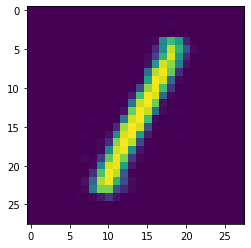

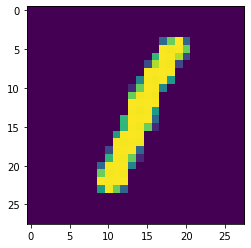

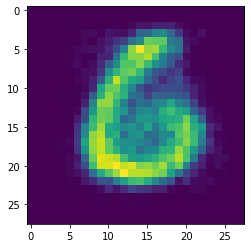

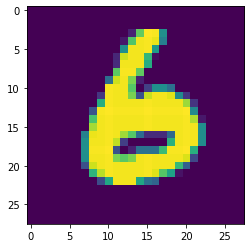

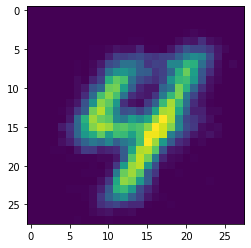

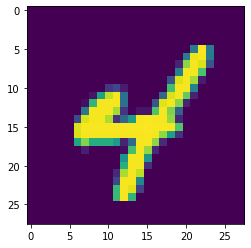

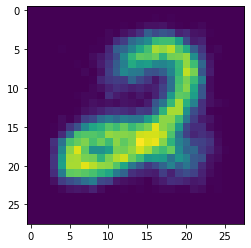

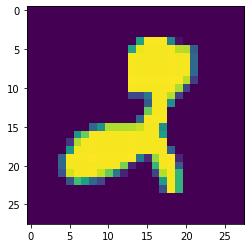

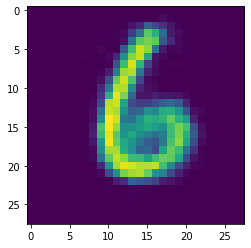

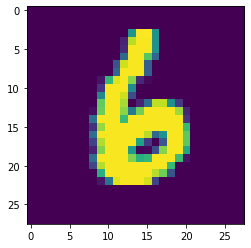

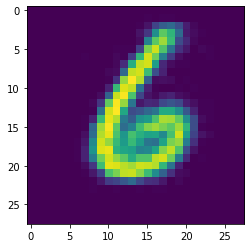

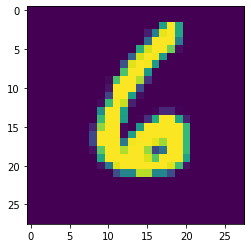

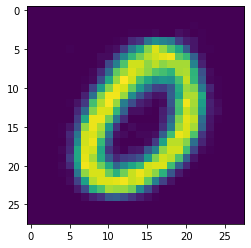

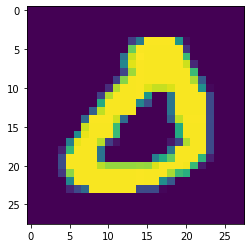

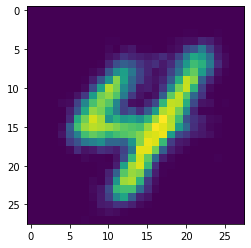

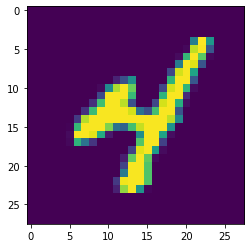

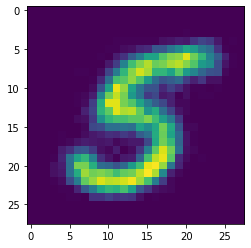

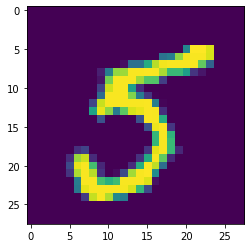

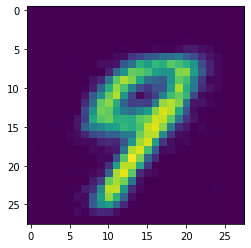

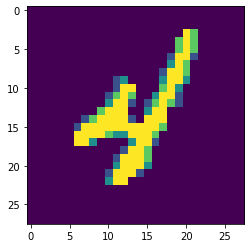

In [19]:
for data_pt_no in range(10):
    plt.imshow(np.mean(p_x[data_pt_no].sample(100),0).reshape((28,28))); plt.show()
    plt.imshow(np_x1[data_pt_no].numpy().reshape((28,28))); plt.show()

## Plot Training Curves

In [20]:
dat1=np.array(dat).T

(90, 250)

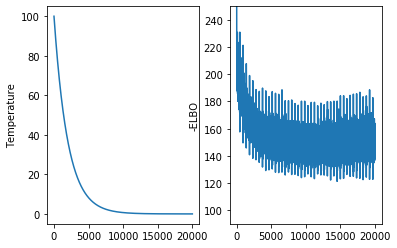

In [21]:
f,axarr=plt.subplots(1,2)
axarr[0].plot(dat1[0],dat1[1])
axarr[0].set_ylabel('Temperature')
axarr[1].plot(dat1[0],dat1[2])
axarr[1].set_ylabel('-ELBO')
axarr[1].set_ylim((90,250))

## Unconditional Generation

This consists of sampling from the prior $p_\theta(y)$ and passing it through the generative model.

In [22]:
batch, N, K = samples.shape

In [23]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [24]:
logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
p_x = tfp.distributions.Bernoulli(logits=logits_x)
np_x = p_x.mean().numpy()

In [25]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
y_img = np.squeeze(np_y)

In [26]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

Text(0.5, 1.0, 'Generated Images')

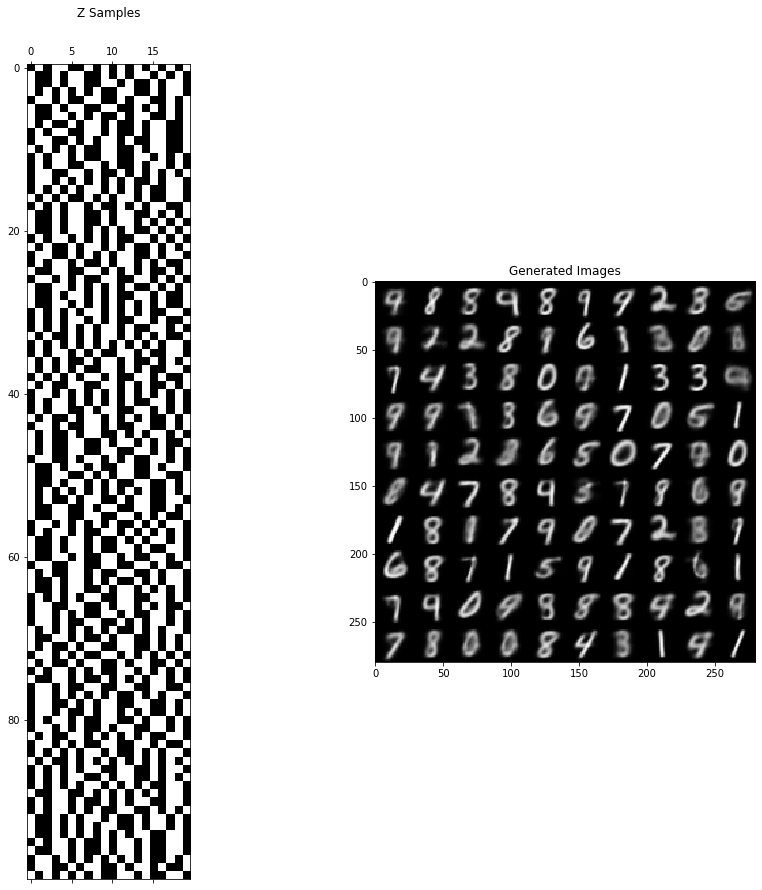

In [27]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')

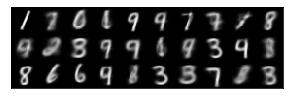

In [40]:
np.random.seed(123)
ys = []
for _ in range(3):
    xs = []
    for _ in range(10):
        np_y = np.zeros((N,K))
        np_y[range(N),np.random.choice(K,N)] = 1
        np_y = np.reshape(np_y,[1,N,K])

        logits_x = vae.calc_logits_x(tf.constant(np_y, dtype=tf.float32)) 
        p_x = tfp.distributions.Bernoulli(logits=logits_x)
        np_x = p_x.mean().numpy()[0].reshape((28,28))
        xs.append(np_x)
    ys.append(np.hstack(xs))
img = np.vstack(ys)   

fig = plt.figure(figsize=(6.4, 1.5), dpi=72)
plt.imshow(img, cmap=plt.cm.gray,interpolation='none')
plt.xticks([],{})
plt.yticks([],{})
plt.savefig("vae_flows.pdf", bbox_inches = 'tight', pad_inches =0)